In [1]:
# Import libraries

from    pulp    import *                # Will be used as the solver
import  numpy               as np                   
import  matplotlib.pyplot   as plt      # Will be used to generate plots                   


In [2]:
# Definition of the problem

model = LpProblem(  name    = "aggregate-planning", 
                    sense   = LpMinimize            )
                    

In [3]:
# Definition of the sets

T       = range(1,13)                   # Set of months:                    T = {1, 2, 3, 4 ... 12}
T_ext   = range(13)                     # Extended time horizon             T = 0 included
M       = ("b", "p")                    # Set of aggregated product groups: basic and pro


In [4]:
# Definition of the parameters

D = (   (28, 14), 
        (20, 10),
        (26, 4),
        (24, 4),
        (18, 6),
        (10, 8),
        (22, 10),
        (20, 12),
        (18, 6),
        (32, 8),
        (34, 14),
        (36, 6)     )           # Monthly demands

wInit   = 86                    # Initial # of workers
h       = 800                   # Hiring cost [$ / worker]
f       = 1400                  # Firing cost [$ / worker]

c       = (250, 500)            # Inventory costs [$ / month]
iInit   = (8, 3)                # Initial inventory

pCost   = (6250, 9750)          # Production costs [$ / unit]

pWf     = (380, 530)            # Production workforce requirements [man*hours / unit]
p       = 180                   # Default productivity of a worker [hours / month]

r       = 420                   # Regular time employee cost [$ / month]
o       = (420/180)*1.5*40      # Overtime employee cost (regular hourly wage * 1.5 * hours) [$ / month]

oLim    = 40                    # Overtime working limit [hours / month]

In [5]:
# Definition of the decision variables

X = {   (i, t): LpVariable( name="X-{model}-{month}".format(    model   = M[i],                                     # Amount of produced models per month
                                                                month   = t     if t>=10 
                                                                                else "0{}".format(t)),              # Standardizing the time indices with two digits
                            lowBound=0                                                                 )
                                                                                for i in range(len(M)) for t in T       }


I = {   (i, t): LpVariable( name="I-{model}-{month}".format(    model   = M[i],                                     # Inventory at the end of the month t
                                                                month   =   t   if t>=10 
                                                                                else "0{}".format(t)),
                            lowBound=0                                                               )              
                                                                                for i in range(len(M)) for t in T_ext   }


W = {   (t): LpVariable(    name="W-{}"             .format(                t   if t>=10                            # # of workers      for     t = 0...12
                                                                                else "0{}".format(t)),
                            lowBound=0                                                               )              
                                                                                for t in T_ext                          }


H = {   (t): LpVariable(    name="H-{}"             .format(                t   if t>=10                            # Hired workers     for     t = 1...12
                                                                                else "0{}".format(t)),
                            lowBound=0                                                               )              
                                                                                for t in T                              }


F = {   (t): LpVariable(    name="F-{}"             .format(                t   if t>=10                            # Fired workers     for     t = 1...12
                                                                                else "0{}".format(t)),
                            lowBound=0                                                               )              
                                                                                for t in T                              }


O = {   (t): LpVariable(    name="O-{}"             .format(                t   if t>=10                            # Overtime amount   for     t = 1...12
                                                                                else "0{}".format(t)),
                            lowBound=0                                                               )              
                                                                                for t in T                              }



In [6]:
# Statement of the objective function: The total annual costs must be minimized.

model += lpSum(
                [   pCost[i]*X[(i,t)]   +                                       # Production costs,       
                    c[i]*I[(i,t)]                                               # and inventory holding costs
                                            for t in T                          # are summed over each month,
                                            for i in range(len(M)   )  ] +      # and each product group.
                [   r*W[t] + o*O[t]     +                                       # Wages,
                    h*H[t] + f*F[t]                                             # and hiring/firing costs
                                            for t in T                 ]        # are summed over each month.                            
                                                                            )


In [7]:
# Definition of the constraints


model += (W[0]      ==  wInit                                                                   # Setting the initial workforce                                   
                                                                                    )


for i in range(len(M)):                                                                         # Setting the initial inventory levels
    model += (I[(i, 0)] ==  iInit[i]
                                                                                    )


for i in range(len(M)):                                                                         # Inventory balance / demand satisfaction
    for t in T:
        model += (  I[(i,t-1)] + X[(i,t)] == I[(i,t)] + D[t-1][i]
                                                                                    )


for t in T:                                                                                     # Workforce balance
    model += (  W[t] == W[t-1] + H[t] - F[t]
                                                                                    )


for t in T:                                                                                     # # of overtime workers cannot exceed the total workforce
    model += (  O[t] <= W[t]
                                                                                    )            


for t in T:                                                                                     # Capacity constraint
    model += (  lpSum(X[(i,t)]*pWf[i] for i in range(len(M))) <= p*W[t] + oLim*O[t]                              
                                                                                    )



In [8]:
model

aggregate-planning:
MINIMIZE
1400*F_01 + 1400*F_02 + 1400*F_03 + 1400*F_04 + 1400*F_05 + 1400*F_06 + 1400*F_07 + 1400*F_08 + 1400*F_09 + 1400*F_10 + 1400*F_11 + 1400*F_12 + 800*H_01 + 800*H_02 + 800*H_03 + 800*H_04 + 800*H_05 + 800*H_06 + 800*H_07 + 800*H_08 + 800*H_09 + 800*H_10 + 800*H_11 + 800*H_12 + 250*I_b_01 + 250*I_b_02 + 250*I_b_03 + 250*I_b_04 + 250*I_b_05 + 250*I_b_06 + 250*I_b_07 + 250*I_b_08 + 250*I_b_09 + 250*I_b_10 + 250*I_b_11 + 250*I_b_12 + 500*I_p_01 + 500*I_p_02 + 500*I_p_03 + 500*I_p_04 + 500*I_p_05 + 500*I_p_06 + 500*I_p_07 + 500*I_p_08 + 500*I_p_09 + 500*I_p_10 + 500*I_p_11 + 500*I_p_12 + 140.0*O_01 + 140.0*O_02 + 140.0*O_03 + 140.0*O_04 + 140.0*O_05 + 140.0*O_06 + 140.0*O_07 + 140.0*O_08 + 140.0*O_09 + 140.0*O_10 + 140.0*O_11 + 140.0*O_12 + 420*W_01 + 420*W_02 + 420*W_03 + 420*W_04 + 420*W_05 + 420*W_06 + 420*W_07 + 420*W_08 + 420*W_09 + 420*W_10 + 420*W_11 + 420*W_12 + 6250*X_b_01 + 6250*X_b_02 + 6250*X_b_03 + 6250*X_b_04 + 6250*X_b_05 + 6250*X_b_06 + 6250*X_b_07

In [9]:
model.solve()
LpStatus[model.status]

'Optimal'

In [10]:
print("z* = ", value(model.objective))

z* =  3143976.3829999994


In [11]:
for v in model.variables():
    print(v.name, " = ", v.varValue)

F_01  =  11.3889
F_02  =  2.94444
F_03  =  0.0
F_04  =  0.0
F_05  =  0.0
F_06  =  0.0
F_07  =  0.0
F_08  =  0.0
F_09  =  0.0
F_10  =  0.0
F_11  =  0.0
F_12  =  0.0
H_01  =  0.0
H_02  =  0.0
H_03  =  0.0
H_04  =  0.0
H_05  =  0.0
H_06  =  0.0
H_07  =  0.0
H_08  =  0.0
H_09  =  4.05833
H_10  =  0.0
H_11  =  0.0
H_12  =  0.0
I_b_00  =  8.0
I_b_01  =  0.0
I_b_02  =  0.0
I_b_03  =  0.0
I_b_04  =  0.0
I_b_05  =  0.0
I_b_06  =  12.7895
I_b_07  =  10.7895
I_b_08  =  8.0
I_b_09  =  17.5013
I_b_10  =  10.2132
I_b_11  =  0.527632
I_b_12  =  0.0
I_p_00  =  3.0
I_p_01  =  0.0
I_p_02  =  0.0
I_p_03  =  0.0
I_p_04  =  0.0
I_p_05  =  0.0
I_p_06  =  0.0
I_p_07  =  0.0
I_p_08  =  0.0
I_p_09  =  0.0
I_p_10  =  0.0
I_p_11  =  0.0
I_p_12  =  0.0
O_01  =  0.0
O_02  =  0.0
O_03  =  0.0
O_04  =  0.0
O_05  =  0.0
O_06  =  0.0
O_07  =  0.0
O_08  =  0.0
O_09  =  0.0
O_10  =  0.0
O_11  =  75.725
O_12  =  75.725
W_00  =  86.0
W_01  =  74.6111
W_02  =  71.6667
W_03  =  71.6667
W_04  =  71.6667
W_05  =  71.6667
W_06

In [12]:
production  = []
inventory   = []

for i in range(len(M)):
    production. append([v.varValue for v in model.variables() if ("X" in v.name) & (M[i] in v.name)])
    inventory.  append([v.varValue for v in model.variables() if ("I" in v.name) & (M[i] in v.name)])
            

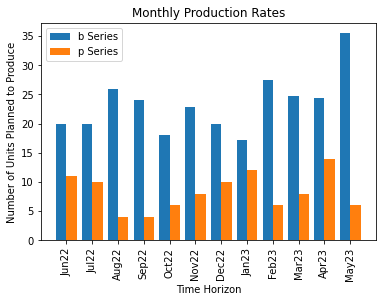

In [13]:
# Plotting the monthly production plan

months = ['Jun22', 'Jul22', 'Aug22', 'Sep22', 'Oct22', 'Nov22',
          'Dec22', 'Jan23', 'Feb23', 'Mar23', 'Apr23', 'May23']

X_axis = np.arange(len(T))          

for i in range(len(production)):
        plt.bar(X_axis - 0.2 + i*0.4, production[i], 0.4, label = "{} Series".format(M[i]))

plt.xticks(X_axis, months, rotation = 90)

plt.xlabel(     "Time Horizon")
plt.ylabel(     "Number of Units Planned to Produce")
plt.title(      "Monthly Production Rates")

plt.legend()
plt.show()



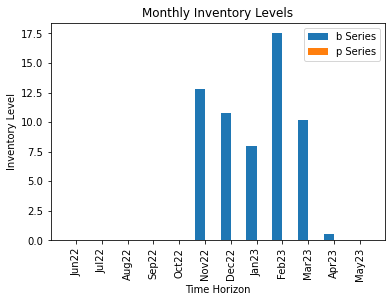

In [14]:
# Plotting the monthly inventory levels

X_axis = np.arange(len(T))          

for i in range(len(inventory)):
        plt.bar(X_axis - 0.2 + i*0.4, inventory[i][1:], 0.4, label = "{} Series".format(M[i]))

plt.xticks(X_axis, months, rotation = 90)

plt.xlabel(     "Time Horizon")
plt.ylabel(     "Inventory Level")
plt.title(      "Monthly Inventory Levels")

plt.legend()
plt.show()

